In [2]:
from pathlib import Path
import sys
import polars as pl
import matplotlib.pyplot as plt
import numpy as np


In [3]:
def find_project_root(start=None):
    if start is None:
        start = Path.cwd().resolve()
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start


PROJECT_ROOT = find_project_root()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [4]:
import settings as S

In [5]:

from src.io.pitch_io import load_preprocessed_pitch
from src.features.pitch_distribution import (
    compute_pitch_distribution_peaks_df,
    theoretical_svarasthanas_cents,
    found_svarasthanas_from_kde,
    flat_region_svara_proportions,
)
from src.utils.plot import plot_svara_window_with_flat_regions
from src.utils.plot_2 import (
    add_flat_threshold_segments_to_ax,
    add_svarasthana_guides_to_ax,
)

# (optional: only if you really use them below)
from src.io.annotation_io import load_annotations
from src.annotations.svara import attach_svara_annotations_to_pitch
from src.features.flatness import extract_flat_regions

In [6]:
SVARA_ID=5

/tmp/ipykernel_12388/494234084.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


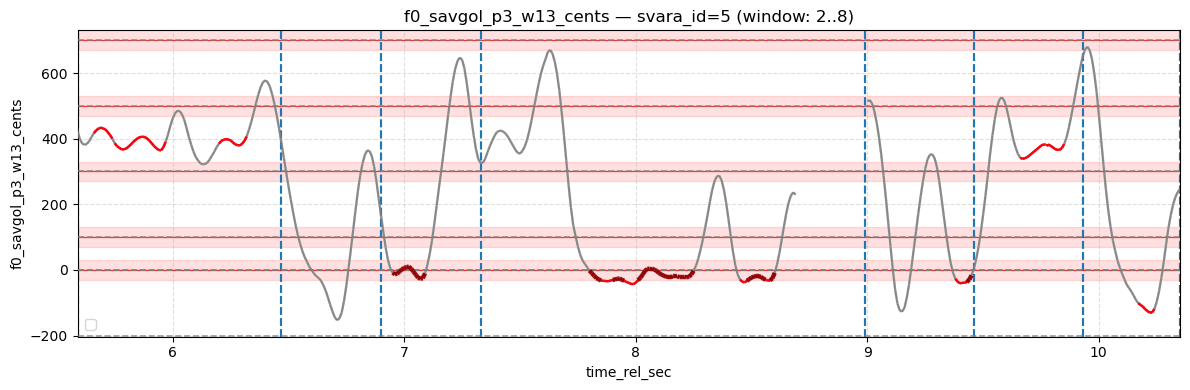

/tmp/ipykernel_12388/494234084.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


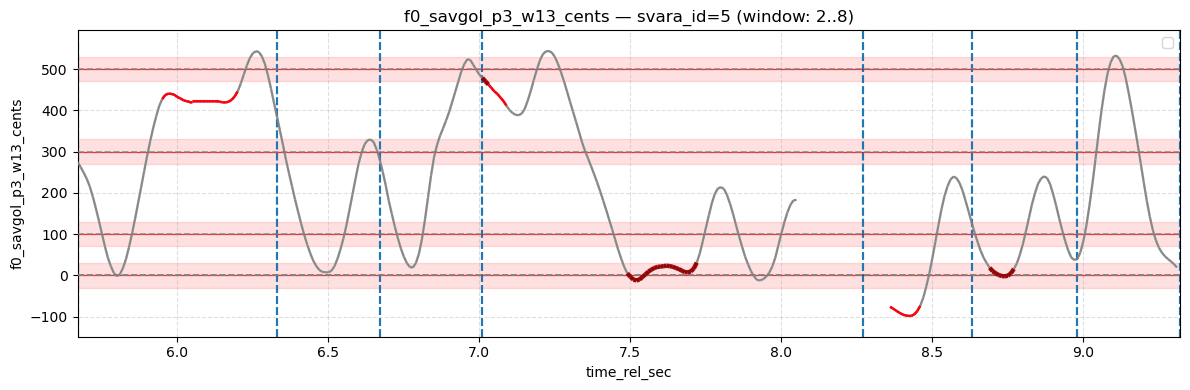

/tmp/ipykernel_12388/494234084.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


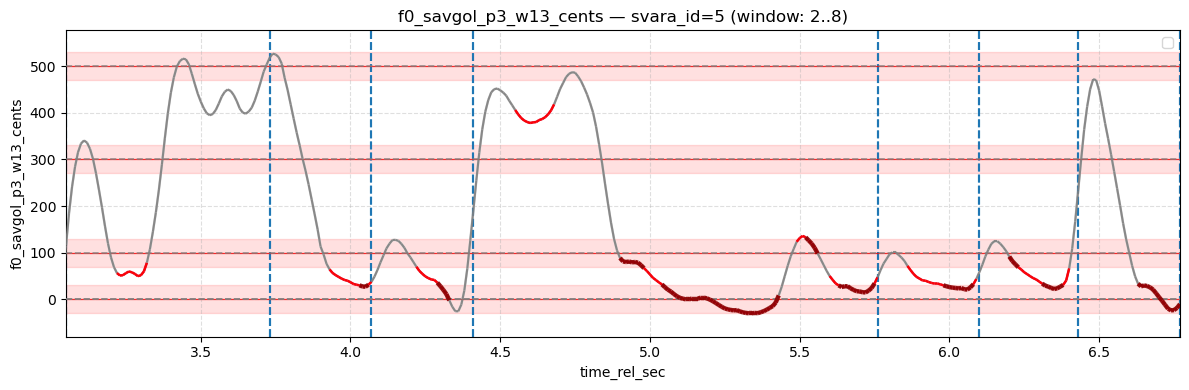

/tmp/ipykernel_12388/494234084.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


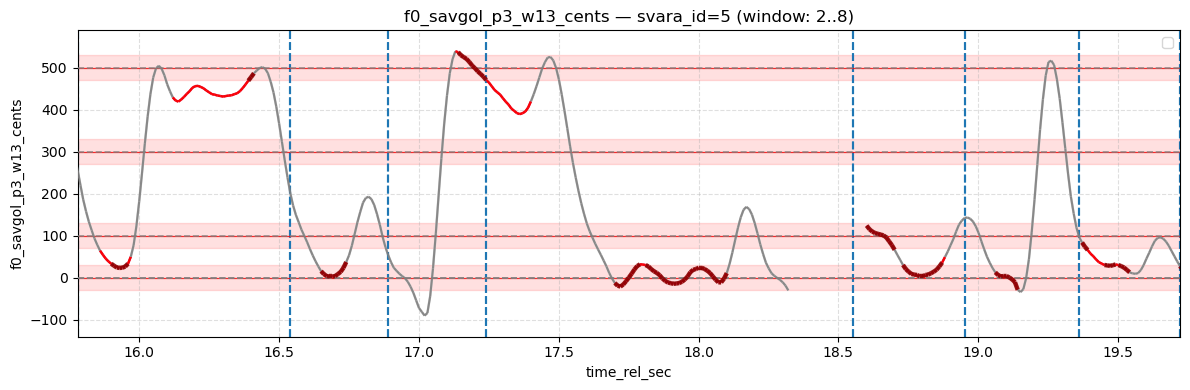

/tmp/ipykernel_12388/494234084.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


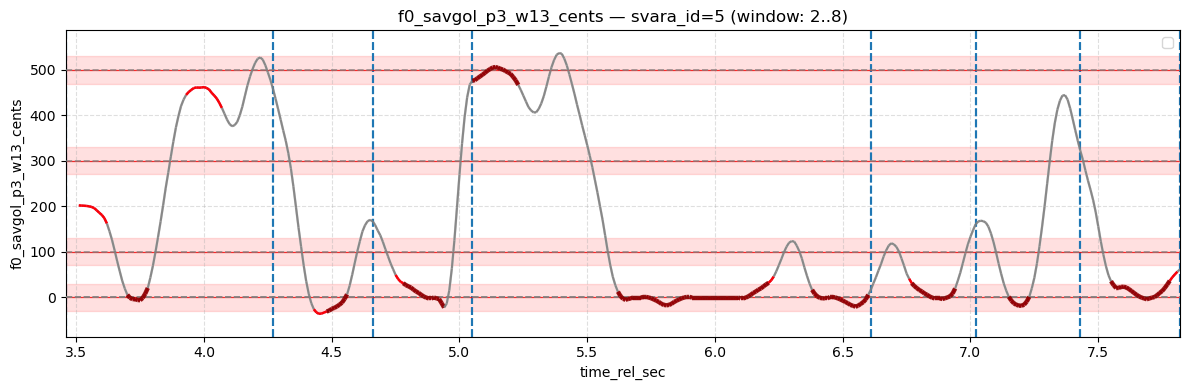

In [8]:



for recording_id in S.SARASUDA_VARNAM:
    tonic_hz = S.SARASUDA_TONICS[recording_id]

    df_pitch = load_preprocessed_pitch(
        recording_id=recording_id,
        root_dir=S.DATA_INTERIM,
        tonic_hz=tonic_hz,
        convert_to_cents=True,
    )        

    flat_path = (
        S.DATA_INTERIM
        / recording_id
        / "flat_regions"
        / f"{recording_id}_flat_regions.parquet"
    )
    df_flat = pl.read_parquet(flat_path)

    grid_cents, density, peak_cents, peak_densities, df_kde_peaks = compute_pitch_distribution_peaks_df(
        df_pitch,
        pitch_col="f0_savgol_p3_w13_cents",
        pitch_unit="cents",
        tonic_hz=tonic_hz,
        recording_id=recording_id,
    )

    theo = theoretical_svarasthanas_cents(raga="saveri", with_octaves=True)

    df_found_kde = found_svarasthanas_from_kde(
        df_kde_peaks,
        theoretical_cents=theo,
        n_largest=5,
        threshold_cents=30,
    )
    found_kde_cents = (
        df_found_kde
        .select("svara_cents")
        .unique()
        .to_series()
        .to_numpy()
    )

    df_hits, df_props = flat_region_svara_proportions(
        df_pitch=df_flat,
        pitch_cents_col="f0_savgol_p3_w13_cents",
        theoretical_cents=theo,
        threshold_cents=30,
    )
    found_flat_cents = (
        df_hits
        .select("svara_cents")
        .unique()
        .to_series()
        .to_numpy()
    )

    # ---- optional / only if you're recomputing flat regions + attaching annotations ----
    ann_path = S.DATA_CORPUS / recording_id / "raw" / f"{recording_id}_ann_svara.tsv"
    df_svaras = load_annotations(file_path=ann_path, annotation_type="svara")
    df_pitch = attach_svara_annotations_to_pitch(df_pitch, df_svaras)
    df_flat = extract_flat_regions(
        df_pitch,
        time_col=S.TIME_COL,
        pitch_col="f0_savgol_p3_w13_cents",
        pitch_unit="cents",
        candidate_col=S.CANDIDATE_COL,
        out_col=S.STABLE_COL,
        min_duration_sec=S.MIN_STABLE_DURATION_SEC,
        cent_tolerance=S.TOLERANCE_CENTS,
        d1_threshold=S.D1_THRESHOLD,
        abs_deriv1_col=getattr(S, "ABS_DERIV1_COL", None),
        verbose=False,
    )

    fig, ax = plot_svara_window_with_flat_regions(
        df_flat,
        svara_id=SVARA_ID,
        pitch_col="f0_savgol_p3_w13_cents",
        stable_col="flat_region",
        window_n=6,
    )

    # filter to visible y-range (pitch axis)
    y0, y1 = ax.get_ylim()
    found_in = np.unique(np.concatenate([found_kde_cents, found_flat_cents]))
    found_in = found_in[(found_in >= y0) & (found_in <= y1)]
    theo_in = theo[(theo >= y0) & (theo <= y1)]

    add_svarasthana_guides_to_ax(
        ax,
        theoretical_cents=theo_in,
        found_cents=found_in,
        threshold_cents=30,
        show_theoretical=True,
        show_found=True,
        show_band=True,
    )

    add_flat_threshold_segments_to_ax(
        ax,
        df_pitch=df_flat,
        pitch_cents_col="f0_savgol_p3_w13_cents",
        theoretical_cents=theo,
        threshold_cents=30,
    )

    ax.legend()
    plt.show()